In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [2]:
# Verbose setting
verbose = True

# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# Open the NetCDF file
ncfile_orig = os.path.join(pvlib_abspath, 'data', 'wrfout_d01.nc')
# In order for cartopy to access the map projection, we MUST read the dataset in with the netCDF4 package. 
ncdata_orig = netCDF4.Dataset(ncfile_orig)
ncfile = os.path.join(pvlib_abspath, 'data', 'wrfout_processed_d01.nc')
ncdata = xr.open_dataset(ncfile)
if verbose:
    print(ncdata)

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-02-07 ... 2011-02-07T23:00:00
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
    wspd_wdir       object ...
    XLONG           (south_north, west_east) float32 ...
    XLAT            (south_north, west_east) float32 ...
    XTIME           (Time) float32 ...
    level           int64 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, s

In [3]:
# Print times
if verbose:
    print(ncdata.Time)
    print(f'\nThe timestr is: {ncdata.Time[0].values}')

<xarray.DataArray 'Time' (Time: 24)>
array(['2011-02-07T00:00:00.000000000', '2011-02-07T01:00:00.000000000',
       '2011-02-07T02:00:00.000000000', '2011-02-07T03:00:00.000000000',
       '2011-02-07T04:00:00.000000000', '2011-02-07T05:00:00.000000000',
       '2011-02-07T06:00:00.000000000', '2011-02-07T07:00:00.000000000',
       '2011-02-07T08:00:00.000000000', '2011-02-07T09:00:00.000000000',
       '2011-02-07T10:00:00.000000000', '2011-02-07T11:00:00.000000000',
       '2011-02-07T12:00:00.000000000', '2011-02-07T13:00:00.000000000',
       '2011-02-07T14:00:00.000000000', '2011-02-07T15:00:00.000000000',
       '2011-02-07T16:00:00.000000000', '2011-02-07T17:00:00.000000000',
       '2011-02-07T18:00:00.000000000', '2011-02-07T19:00:00.000000000',
       '2011-02-07T20:00:00.000000000', '2011-02-07T21:00:00.000000000',
       '2011-02-07T22:00:00.000000000', '2011-02-07T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * Time       (Time) datetime64[ns] 2011-0

In [4]:
def create_plot(cart_proj, data, data_orig, lats, lons, title_str='', save_fig=False, fig_path='./'):
    # Create a figure
    fig = plt.figure(figsize=(12,6))
    # Set the GeoAxes to the projection used by WRF
    ax = plt.axes(projection=cart_proj)

    # Make the countour lines for filled contours for the GHI
    contour_levels = np.linspace(0, 5, 22)
    plt.contourf(to_np(lons), to_np(lats), to_np(data), contour_levels,
                 transform=crs.PlateCarree(),
                 cmap=get_cmap("hot_r"))

    # Format the plot
    format_plot(data_orig, ax, title_str)

    # Save the figure(s)
    if save_fig:
        plt.savefig(fig_path, transparent=True, bbox_inches='tight')
        
        
def format_plot(lim_data, ax, title_str=''):
    
    # Download and add the states, coastlines, and lakes
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.5, edgecolor="black")
#     ax.coastlines(resolution='10m', linewidth=0.8)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))

    # Add a color bar
    plt.colorbar(ax=ax, shrink=.98)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(lim_data))
    ax.set_ylim(cartopy_ylim(lim_data))

    # Add the gridlines
#     ax.gridlines(color="black", linestyle="dotted")
    
    # Add the axis title
    plt.title(title_str)

In [10]:
def plot_daily_fitness(times, hourly=False, save_fig=False, fig_path='./'):
    # Define the time indicies from the times variable
    time_indicies = range(0, len(times))
    # Format the times for title slides
    times_strings_f = times.dt.strftime('%b %d, %Y %H:%M')
    # Get the desired variable(s)
    for tidx in time_indicies:
        timestr = times[tidx].values
        timestr_f = times_strings_f[tidx].values
        if hourly:
            title_str = f'Global Horizontal Irradiance (kW m-2)\n{timestr_f} (UTC)'
        else:
            time_string_f = times[0].dt.strftime('%b %d, %Y')
            title_str = f'Global Horizontal Irradiance (kWh m-2 day-1) \n{time_string_f.values}'
        dni_orig = getvar(ncdata_orig, "SWDDNI", timeidx=tidx)
        
        if not hourly and tidx != 0:
            dni = dni + ncdata.dni.sel(Time=timestr)
            ghi = ghi + (ncdata.ghi.sel(Time=timestr) / 1000)
        else:
            dni = ncdata.dni.sel(Time=timestr)
            ghi = ncdata.ghi.sel(Time=timestr) / 1000
            

        # Get the latitude and longitude points
        lats, lons = latlon_coords(dni_orig)

        # Get the cartopy mapping object
        cart_proj = get_cartopy(dni_orig)
        
        if hourly:
            create_plot(cart_proj, ghi, dni_orig, lats, lons, title_str, save_fig, fig_path)
    if not hourly:
        create_plot(cart_proj, ghi, dni_orig, lats, lons, title_str, save_fig, fig_path)

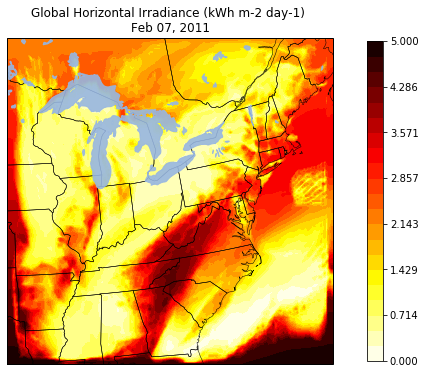

In [11]:
plot_daily_fitness(ncdata.Time, hourly=False)